In [199]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from pathlib import Path
import matplotlib.pyplot as plt
import random

In [200]:
train_df = pd.read_csv("Downloads/pokemon Classification/train.csv")

In [201]:
labelOf = {}
names = train_df.iloc[:,0]
labels = train_df.iloc[:,1]
for i in range(len(names)):
    labelOf[names[i]] = labels[i]

In [202]:
p = Path("Downloads/pokemon Classification/Images_train")
all_images = p.glob("*jpg")
# Now we have path of all images
# We'll use keras image to get image data from path
# convert that to an array
# store it in image data list
# convert that list in array (later)
images_data = []
labels_data = []
for i in all_images:
    name = str(i).split('\\')[-1]
    img = image.load_img(path=i, target_size=(32,32))
    img_array = image.img_to_array(img)
    images_data.append(img_array)
    labels_data.append(labelOf[name])

C:\Users\anant\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [203]:
images_data = np.array(images_data, dtype='float32')/255.0
labels_data = np.array(labels_data)

In [204]:
images_data.shape

(304, 32, 32, 3)

In [205]:
#Reshape Images
images_data = images_data.reshape((images_data.shape[0], -1))
print(images_data.shape)

(304, 3072)


In [206]:
#Shuffle
combined = list(zip(images_data, labels_data))
random.shuffle(combined)
images_data[:], labels_data[:] = zip(*combined)

In [207]:
class SVM:
    
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
    
    def hingeLoss(self,W,b,X,y):
        loss = 0.0
        loss += 0.5 * np.dot(W,W.T)
        m = X.shape[0]
        for i in range(m):
            ti = y[i] * (np.dot(W, X[i].T) + b)
            loss += self.C * max(0, (1-ti))
        return loss[0][0]
    
    def fit(self,X,y,batch_size=25, learning_rate=0.0001, max_itr=500):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        n = learning_rate
        C = self.C
        
        # Initializing Model Parameters
        W = np.zeros((1,no_of_features))
        bias = 0.0
        
        # Training
        losses = []
        
        for itr in range(max_itr):
            
            l = self.hingeLoss(W, bias, X, y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0, no_of_samples, batch_size):
                gradw = 0
                gradb = 0
                
                for j in range(batch_start, batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti = y[i] * (np.dot(W,X[i].T)+bias)
                        
                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += C * y[i] * X[i]
                            gradb += C * y[i]
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        
        self.W = W
        self.b = bias
        plt.plot(losses)
        plt.show
        return W, bias, losses 
    

In [208]:
CLASSES = (np.unique(labels_data))
CLASSES

array(['Bulbasaur', 'Charmander', 'Pikachu'], dtype='<U10')

In [209]:
def classwiseData(X, y):
    data = {}
    for i in CLASSES:
        data[i] = []
    for i in range(X.shape[0]):
        data[y[i]].append(X[i])
    for k in CLASSES:
        data[k] = np.array(data[k])
    return data

In [210]:
data = classwiseData(images_data, labels_data)
# print(len(data['Pikachu']))

In [211]:
# data

In [212]:
def getDataPair(d1, d2):
    l1 , l2 = d1.shape[0] , d2.shape[0]
    features = d1.shape[1]
    
    data = np.zeros((l1+l2, features))
    data[:l1,:] = d1
    data[l1:,:] = d2
    
    data_labels = np.zeros((l1+l2,))
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data, data_labels

In [213]:
mySVM = SVM()

In [214]:
def trainSVM(X, y):
    svm_classifiers = {}
    
    for i in range(len(CLASSES)):
        svm_classifiers[CLASSES[i]] = {}
        for j in range(i+1,len(CLASSES)):
            c1 = CLASSES[i]
            c2 = CLASSES[j]
            x_pair, y_pair = getDataPair(data[c1], data[c2])
            w, b, l = mySVM.fit(x_pair, y_pair)
            svm_classifiers[c1][c2] = w,b
    return svm_classifiers

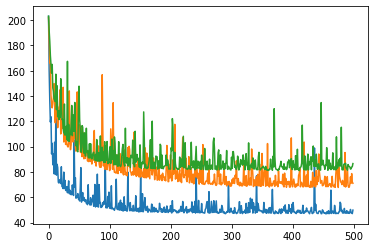

In [215]:
svm_classifiers = trainSVM(images_data, labels_data)

In [216]:
def binaryPredict(X, W, b):
    z = np.dot(X, W.T) + b
    if z>=0:
        return 1;
    else:
        return -1

In [217]:
def predict(X):
    count = np.zeros((len(CLASSES),))
    
    for i in range(len(CLASSES)):
        for j in range(i+1, len(CLASSES)):
            c1 = CLASSES[i]
            c2 = CLASSES[j]
            w, b = svm_classifiers[c1][c2]
            if binaryPredict(X, w, b)==1:
                count[j] += 1
            else:
                count[i] += 1
    idx = np.argmax(count)
    return CLASSES[idx]

## Load Test Data

In [231]:
p2 = Path("Downloads/pokemon Classification/Images_test")
test_images = p2.glob("*jpg")
test_images_data = []
test_labels = []
for i in test_images:
    test_labels.append((str(i).split('\\')[-1]))
    img = image.load_img(i, target_size=(32,32))
    img_array = image.img_to_array(img)
    test_images_data.append(img_array)

#  Flattening
test_images_data = np.array(test_images_data)
test_images_data = test_images_data.reshape((test_images_data.shape[0],-1));
print(test_images_data.shape)

(123, 3072)


In [233]:
test_dict = {}
for i in range(test_images_data.shape[0]):
    test_dict[test_labels[i]] = predict(test_images_data[i])

In [234]:
test_df = pd.read_csv("Downloads/pokemon Classification/Sample_submission.csv")

In [245]:
test_df

,ImageId,NameOfPokemon
0,1106.jpg,Pikachu
1,2236.jpg,Pikachu
2,1131.jpg,Pikachu
3,2221.jpg,Pikachu
4,2011.jpg,Pikachu
...,...,...
118,1124.jpg,Pikachu
119,2014.jpg,Pikachu
120,2235.jpg,Pikachu
121,1126.jpg,Pikachu


In [246]:
for i in range(test_df.shape[0]):
    name = test_df.loc[i][0]
    test_df.loc[i][1] = test_dict[name]

In [247]:
test_df

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Pikachu
4,2011.jpg,Charmander
...,...,...
118,1124.jpg,Bulbasaur
119,2014.jpg,Pikachu
120,2235.jpg,Charmander
121,1126.jpg,Bulbasaur


In [249]:
test_df.to_csv('pokemon_sub.csv', index=False)